# Debugging the Pipline

in this notebook we want to get our pipeline up and running and test the key components




In [1]:
%load_ext autoreload
%autoreload 2
%cd /mnt/activeCell-ACDC

#import sys
#sys.path.append("..")

import json
import random as rd
import matplotlib.image as mpimg
import tqdm
from matplotlib import cm

import cv2
import wandb
import torch
import os
import numpy as np

from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor

from src.globals import *
from src.visualization.show_image import show_image
from src.register_datasets import register_datasets, get_dataset_name
from src.test import do_test
from src.train import do_train
from src.predict import predict_image_in_acdc
from src.config_builder import get_config



/mnt/activeCell-ACDC


/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
DATASET = ACDC_LARGE#ACDC_LAST_IMAGES
CONFIG_NAME = "classes_acdc_large"
TEST = "test"
TRAIN = "train"

In [7]:

def plot_trio(image_json, dataset=DATASET, data_type=TEST, config_name=CONFIG_NAME):
    
    logger = setup_logger(output="./log/main.log")
    logger.setLevel(0)

    # ground truth
    print(image_json["file_name"])
    raw_im = cv2.imread(image_json["file_name"])

    visualizer = Visualizer(raw_im[:, :, ::-1], metadata=MetadataCatalog.get(get_dataset_name(dataset,data_type)), scale=2)
    out = visualizer.draw_dataset_dict(image_json)
    ground_truth_im = out.get_image()[:, :, ::-1]
    
    # prediction
    cfg = get_config(config_name)
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "best_model.pth")  # path to the model we just trained
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05   # set a custom testing threshold
    predictor = DefaultPredictor(cfg)

    outputs = predictor(raw_im)
    
    v = Visualizer(raw_im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))


    predicted_instances = np.asarray(outputs["instances"].pred_masks.to("cpu"))
    predicted_mask = np.zeros(predicted_instances[0].shape)

    for id in range(len(predicted_instances)):
        np.place(predicted_mask, predicted_instances[id], 1)

    predicted_im = out.get_image()[:, :, ::-1]


    visualizer = Visualizer(np.zeros(raw_im[:, :, ::-1].shape), metadata=MetadataCatalog.get(get_dataset_name(dataset,data_type)), scale=2)
    new_im_json = image_json.copy()
    new_im_json["annotations"] = []
    for anno in image_json["annotations"]:
        new_anno = anno.copy()
        new_anno["bbox"] = [0,0,0,0]
        new_im_json["annotations"].append(new_anno)
    out = visualizer.draw_dataset_dict(new_im_json)
    print(np.array(out.get_image()[:, :, ::-1]).shape)
    ground_truth_mask = (np.array(out.get_image()[:, :, ::-1]) != 0).max(axis=2).astype(np.uint8)
    ground_truth_mask = cv2.resize(ground_truth_mask*255, dsize=(predicted_mask.shape[1],predicted_mask.shape[0]), interpolation=cv2.INTER_CUBIC)


    print("############################################################################")
    print(image_json["file_name"])

    show_image([raw_im, ground_truth_im,predicted_im, ground_truth_mask, predicted_mask, (ground_truth_mask > 0) - predicted_mask])

In [8]:
register_datasets()
dataset_json_train = DatasetCatalog.get(get_dataset_name(DATASET,"train"))
dataset_json_test = DatasetCatalog.get(get_dataset_name(DATASET,"test"))

registering acdc_small dataset
registering acdc_large dataset



Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [9]:
def plot_ground_truth(image_json, dataset=DATASET, data_type=TEST):

    in_image = cv2.imread(image_json["file_name"])
    visualizer = Visualizer(in_image[:, :, ::-1], metadata=MetadataCatalog.get(get_dataset_name(dataset,data_type)), scale=2)
    out = visualizer.draw_dataset_dict(image_json)
    out_image = out.get_image()[:, :, ::-1]
    #show_image([in_image,out_image])
    show_image([in_image,out_image])

def plot_prediction(image_json, config_name=CONFIG_NAME):

    cfg = get_config(config_name)
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "best_model.pth")  # path to the model we just trained
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9   # set a custom testing threshold
    predictor = DefaultPredictor(cfg)

    im = cv2.imread(image_json["file_name"])
    outputs = predictor(im)
    
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    show_image([im,out.get_image()[:, :, ::-1]])

def plot_trio(image_json, dataset=DATASET, data_type=TEST, config_name=CONFIG_NAME):
    
    # ground truth
    raw_im = cv2.imread(image_json["file_name"])

    visualizer = Visualizer(raw_im[:, :, ::-1], metadata=MetadataCatalog.get(get_dataset_name(dataset,data_type)), scale=2)
    out = visualizer.draw_dataset_dict(image_json)
    ground_truth_im = out.get_image()[:, :, ::-1]
    
    # prediction
    cfg = get_config(config_name)
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "best_model.pth")  # path to the model we just trained
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9   # set a custom testing threshold
    predictor = DefaultPredictor(cfg)

    outputs = predictor(raw_im)
    
    v = Visualizer(raw_im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))


    predicted_instances = np.asarray(outputs["instances"].pred_masks.to("cpu"))
    predicted_mask = np.zeros(predicted_instances[0].shape)

    for id in range(len(predicted_instances)):
        np.place(predicted_mask, predicted_instances[id], 1)

    predicted_im = out.get_image()[:, :, ::-1]


    visualizer = Visualizer(np.zeros(raw_im[:, :, ::-1].shape), metadata=MetadataCatalog.get(get_dataset_name(dataset,data_type)), scale=2)
    new_im_json = image_json.copy()
    new_im_json["annotations"] = []
    for anno in image_json["annotations"]:
        new_anno = anno.copy()
        new_anno["bbox"] = [0,0,0,0]
        new_im_json["annotations"].append(new_anno)
    out = visualizer.draw_dataset_dict(new_im_json)
    print(np.array(out.get_image()[:, :, ::-1]).shape)
    ground_truth_mask = (np.array(out.get_image()[:, :, ::-1]) != 0).max(axis=2).astype(np.uint8)
    ground_truth_mask = cv2.resize(ground_truth_mask*255, dsize=(predicted_mask.shape[1],predicted_mask.shape[0]), interpolation=cv2.INTER_CUBIC)


    print("############################################################################")
    print(image_json["file_name"])

    show_image([raw_im, ground_truth_im,predicted_im, ground_truth_mask, predicted_mask, (ground_truth_mask > 0) - predicted_mask])
    

## SHOW IMAGES AND GROUND TRUTHS

(1144, 1192, 3)
############################################################################
./data/acdc_large/test/images/acdc_data3_20210722_pos_17_162.png


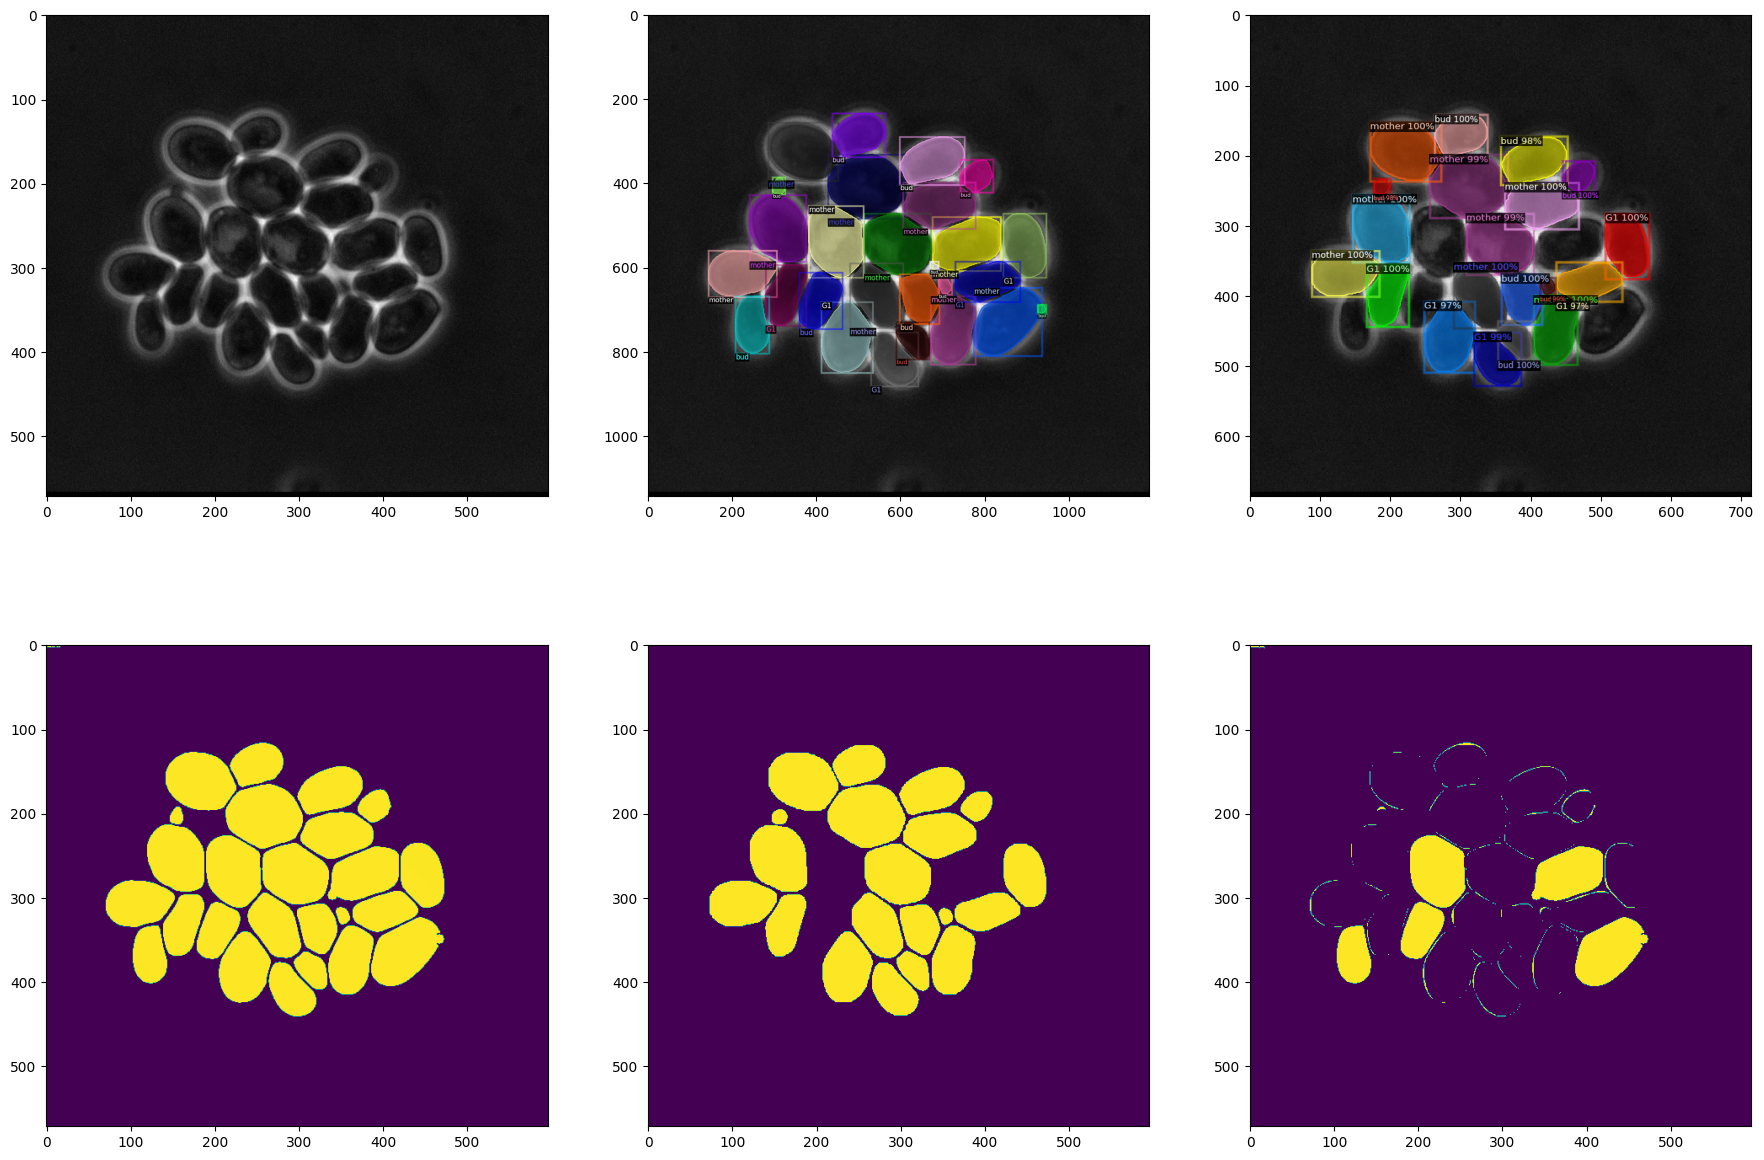

(1604, 1672, 3)
############################################################################
./data/acdc_large/test/images/acdc_data3_20210722_pos_13_109.png


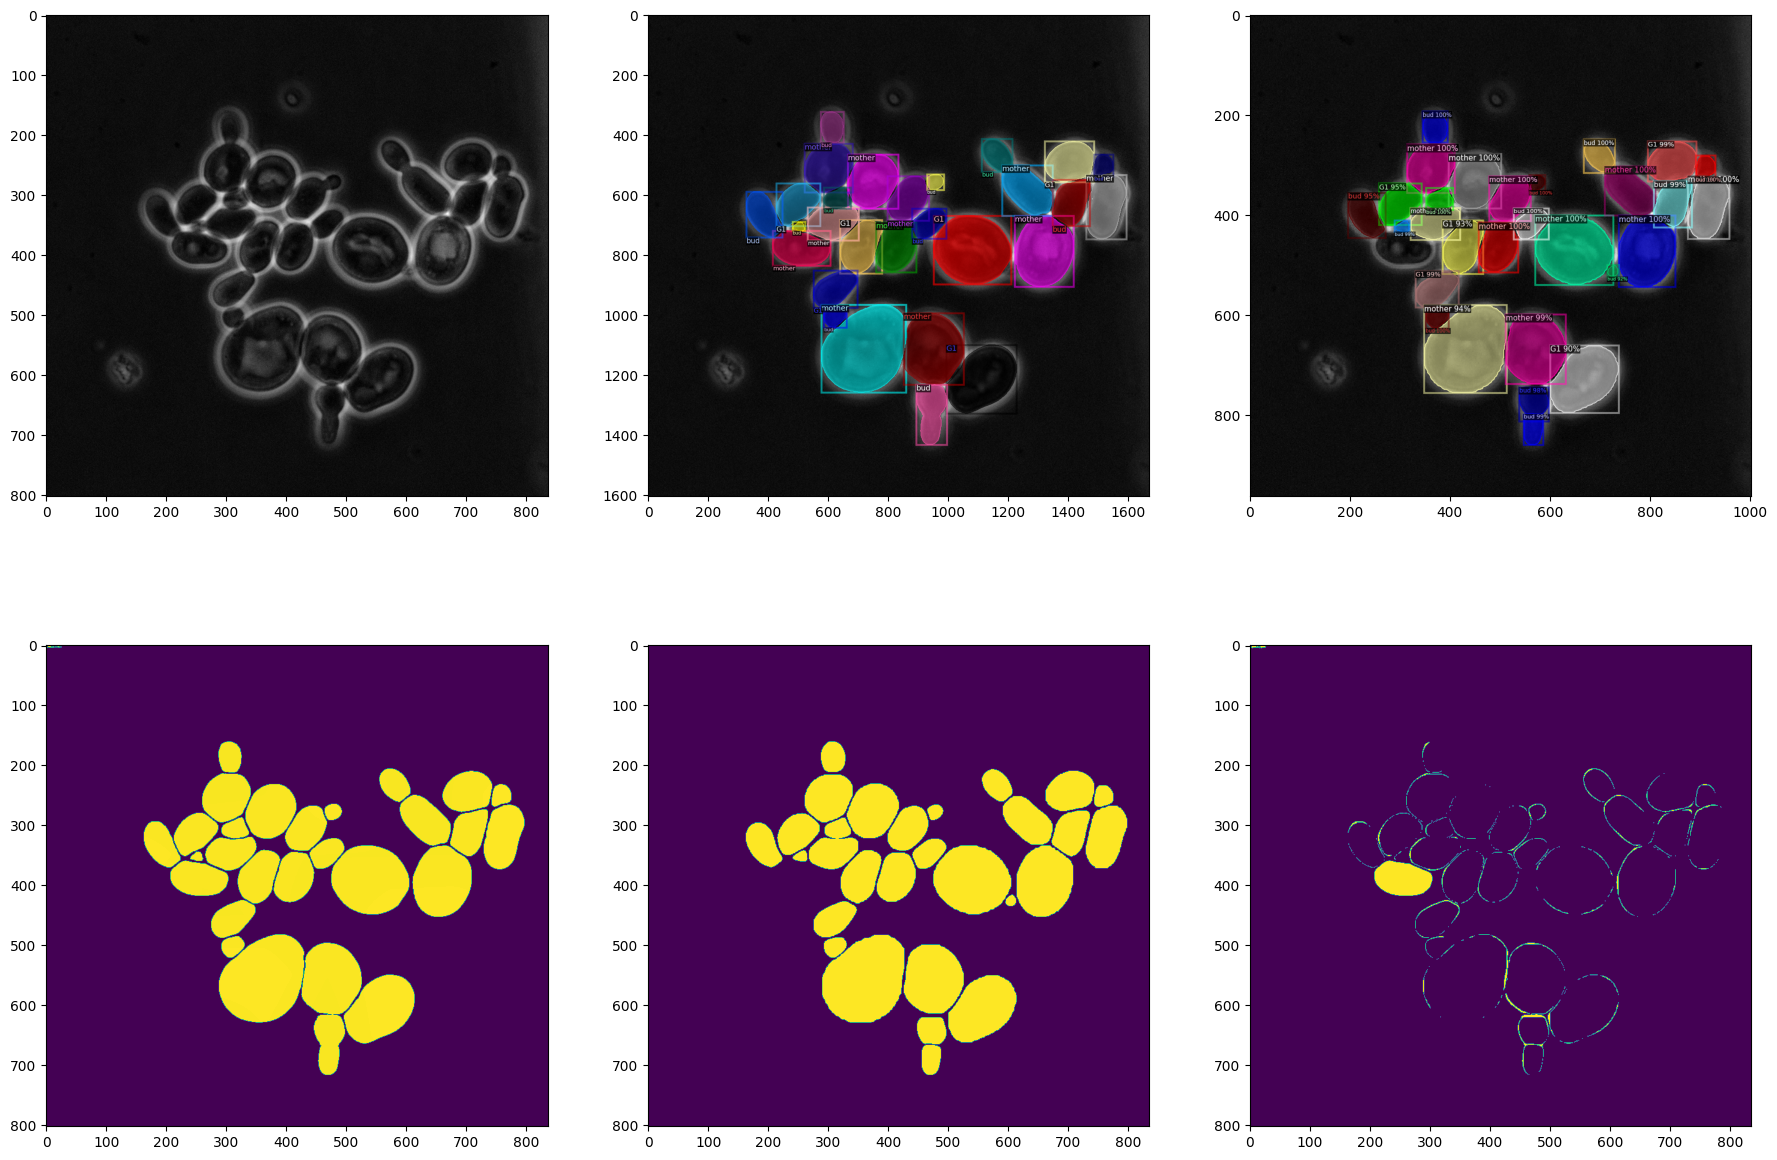

(1446, 1608, 3)
############################################################################
./data/acdc_large/test/images/acdc_data3_Yagya_SCD_WT_pos_3_62.png


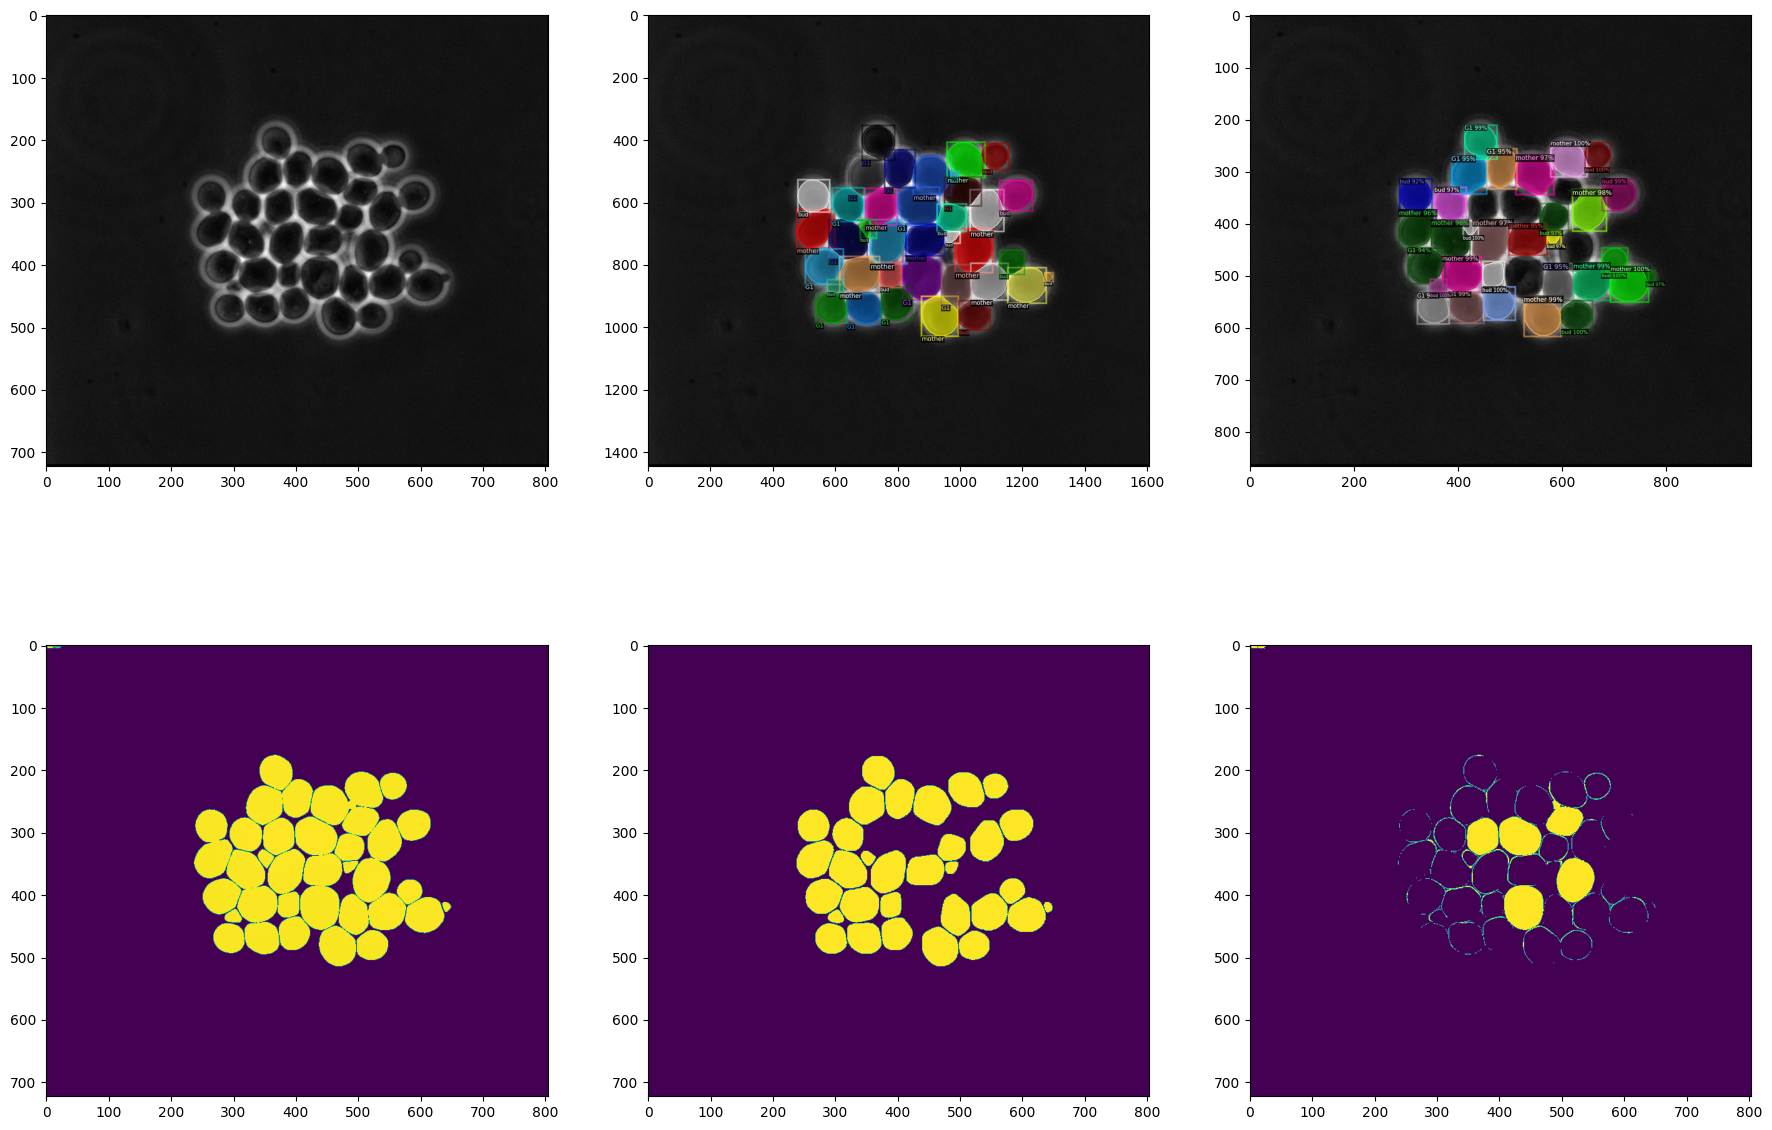

In [11]:
rd.seed(1337)
for ds_json in rd.sample(dataset_json_test, 3):
    plot_trio(ds_json)

In [ ]:
def evaluate(config_name=CONFIG_NAME, dataset=DATASET, data_type=TEST):

    cfg = get_config(config_name)
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "best_model.pth")  # path to the model we just trained
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
    predictor = DefaultPredictor(cfg)


    evaluator = COCOEvaluator(get_dataset_name(dataset,data_type), output_dir=cfg.OUTPUT_DIR)
    data_loader = build_detection_test_loader(cfg, get_dataset_name(dataset,data_type))
    evaluator = COCOEvaluator(get_dataset_name(dataset,data_type), output_dir=cfg.OUTPUT_DIR)
    results_i = inference_on_dataset(predictor.model, data_loader, evaluator)
    print(results_i)
    # %%capture
    result_dict = {}
    ds_json = DatasetCatalog.get(get_dataset_name(dataset,data_type))
    for image in ds_json:
        result = evaluator.evaluate(image["image_id"])
        result_dict[image["file_name"]] = result

    with open(os.path.join(cfg.OUTPUT_DIR, "aps.txt"), "w") as file:
        file.write(str(result_dict))

    return result_dict

result_dict = evaluate()


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.792
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.906
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.886
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.468
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.870
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.029
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.248
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.822
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.489
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.903
 Average Recall     (AR) @[ IoU=0.50:0


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.855
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.970
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.970
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.641
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.896
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.021
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.214
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.886
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.650
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.924
 Average Recall     (AR) @[ IoU=0.50:0

In [ ]:
import pandas as pd

segm_aps = []
bbox_aps = []
image_names = []

for key in result_dict.keys():
    image_names.append(key)
    segm_aps.append(result_dict[key]["segm"]["AP"])
    bbox_aps.append(result_dict[key]["bbox"]["AP"])

df = pd.DataFrame(data={"image_name": image_names, "segm_ap": segm_aps, "bbox_ap": bbox_aps})


In [ ]:
for index, row in df.sort_values(by=["segm_ap", "bbox_ap"]).head(10).iterrows():
    plot_trio(dataset_json_test[index])
    print("segm_ap: ",row["segm_ap"], "\t bbox_ap: ", row["bbox_ap"])
#df.sort_values(by=["segm_ap", "bbox_ap"]).head(20)
#plot_trio(dataset_json_test[11])